# Chapter 2: Working with Text Data

An intro into data preprocessing and preparation for LLMs.

In [ ]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv
%cd ".."

In [ ]:
import os
import re

import tiktoken
import torch
from torch.utils.data import DataLoader, Dataset

from src import locations

In [ ]:
verdict_path = os.path.join(
    locations.DATA_SUBDIR["external"], "the_verdict_edith_wharton.txt"
)
with open(verdict_path, "r", encoding="utf-8") as f:
    raw_text_verdict = f.read()
print("Number of characters: ", len(raw_text_verdict))
print(raw_text_verdict[:99])

Now that we have the text we can try tokenising:

In [ ]:
preprocessed_verdict = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text_verdict)
preprocessed_verdict = [
    item.strip() for item in preprocessed_verdict if item.strip()
]
print(len(preprocessed_verdict))

In [ ]:
print(preprocessed_verdict[:30])

Now we turn each of these tokens into an integer ID.

In [ ]:
all_words_verdict = sorted(set(preprocessed_verdict))
vocab_size_verdict = len(all_words_verdict)
print(f"Vocab size: {vocab_size_verdict}")

In [ ]:
vocab_verdict = {
    token: integer for token, integer in enumerate(all_words_verdict)
}
for i, item in enumerate(vocab_verdict.items()):
    print(item)
    if i > 50:
        break

Now we wrap this up in a class and try it on the text.

In [ ]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i: s for s, i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.int_to_str[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.str_to_int[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r"\1", text)
        return text

In [ ]:
tokenizer = SimpleTokenizerV1(vocab_verdict)
text = """"It's the last he painted, you know," Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

In [ ]:
tokenizer.decode(ids)

Now we extend the class to deal with tokens not previously seen, and to demarcate between texts.

In [ ]:
all_tokens_verdict = sorted(list(set(preprocessed_verdict)))
all_tokens_verdict.extend(["<|endoftext|>", "<|unk|>"])
vocab_verdict = {
    token: integer for integer, token in enumerate(all_tokens_verdict)
}
print(len(vocab_verdict.items()))
# Print the last few to check this has worked
for i, item in enumerate(list(vocab_verdict.items())[-5:]):
    print(item)

In [ ]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i: s for s, i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int else "<|unk|>"
            for item in preprocessed
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r"\1", text)
        return text

In [ ]:
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
print(text)

In [ ]:
tokenizer = SimpleTokenizerV2(vocab_verdict)
print(tokenizer.encode(text))

In [ ]:
print(tokenizer.decode(tokenizer.encode(text)))

Now we try a more sophisticated approach to tokenising, using byte pair encoding.

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

In [ ]:
text = "Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace."
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)

In [ ]:
strings = tokenizer.decode(integers)
print(strings)

In [ ]:
enc_text = tokenizer.encode(raw_text_verdict)
print(len(enc_text))

In [ ]:
# Drop the first 50 tokens, makes the example more interesting
enc_sample = enc_text[50:]

In [ ]:
context_size = 4
x = enc_sample[:context_size]
y = enc_sample[1 : context_size + 1]
print(f"x: {x}")
print(f"y: {y}")
# Show what we have and are trying to predict at each step with an LLM
for i in range(1, context_size + 1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(context, "---->", desired)
# Repeat with words rather than the id's
for i in range(1, context_size + 1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

In [ ]:
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)  # A Tokenize the entire text

        for i in range(
            0, len(token_ids) - max_length, stride
        ):  # B Use a sliding window to chunk the book into overlapping sequences of max_length
            input_chunk = token_ids[i : i + max_length]
            target_chunk = token_ids[i + 1 : i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        # C Return the total number of rows in the dataset
        return len(self.input_ids)

    def __getitem__(self, idx):
        # D Return a single row from the dataset
        return self.input_ids[idx], self.target_ids[idx]

In [ ]:
def create_dataloader_v1(
    txt,
    batch_size=4,
    max_length=256,
    stride=128,
    shuffle=True,
    drop_last=True,
    num_workers=0,
):
    tokenizer = tiktoken.get_encoding("gpt2")  # A
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)  # B
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,  # C
        num_workers=0,  # D
    )
    return dataloader

In [ ]:
with open(verdict_path, "r", encoding="utf-8") as f:
    raw_text_verdict = f.read()
dataloader = create_dataloader_v1(
    raw_text_verdict, batch_size=1, max_length=4, stride=1, shuffle=False
)
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

In [ ]:
second_batch = next(data_iter)
print(second_batch)

In [ ]:
dataloader = create_dataloader_v1(
    raw_text_verdict, batch_size=8, max_length=4, stride=4
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Next step is to build embeddings. The example here is v small, but illustrates how it works.

In [ ]:
input_ids = torch.tensor([2, 3, 5, 1])
# Suppose we have only six words in the vocab, and want length-3 embeddings
vocab_size = 6
output_dim = 3
torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
# One row per word in the vocab, one column per element of the embedding vectors
print(embedding_layer.weight)

In [ ]:
# Can extract embedding vectors by index. This will grab index 3, i.e. the fourth row of the previous matrix.
print(embedding_layer(torch.tensor([3])))

The book compares this use of an embedding layer to one-hot encoding followed by matrix multiplication, and directs us to some [extra code](https://github.com/rasbt/LLMs-from-scratch/blob/main/ch02/03_bonus_embedding-vs-matmul/embeddings-and-linear-layers.ipynb) that walks through the comparison

## Using `nn.Embedding`

In [ ]:
# Suppose we have the following 3 training examples,
# which may represent token IDs in a LLM context
idx = torch.tensor([2, 3, 1])

# The number of rows in the embedding matrix can be determined
# by obtaining the largest token ID + 1.
# If the highest token ID is 3, then we want 4 rows, for the possible
# token IDs 0, 1, 2, 3
num_idx = max(idx) + 1

# The desired embedding dimension is a hyperparameter
out_dim = 5

# Let's implement a simple embedding layer:

# We use the random seed for reproducibility since
# weights in the embedding layer are initialized with
# small random values
torch.manual_seed(123)

embedding = torch.nn.Embedding(num_idx, out_dim)
# We can optionally take a look at the embedding weights:
print(embedding.weight)

In [ ]:
# We can then use the embedding layers to obtain the vector representation of a training example with ID 1:

embedding(torch.tensor([1]))

In [ ]:
# Now, let's convert all the training examples we have defined previously:
idx = torch.tensor([2, 3, 1])
embedding(idx)

## Using nn.Linear

Now, we will demonstrate that the embedding layer above accomplishes exactly the same as nn.Linear layer on a one-hot encoded representation in PyTorch. First, let's convert the token IDs into a one-hot representation:

In [ ]:
onehot = torch.nn.functional.one_hot(idx)
onehot

Next, we initialize a `Linear` layer, which caries out a matrix multiplication $XW^{T}$:

In [ ]:
torch.manual_seed(123)
linear = torch.nn.Linear(num_idx, out_dim, bias=False)
linear.weight

Note that the linear layer in PyTorch is also initialized with small random weights; to directly compare it to the `Embedding` layer above, we have to use the same small random weights, which is why we reassign them here:

In [ ]:
linear.weight = torch.nn.Parameter(embedding.weight.T)

Now we can use the linear layer on the one-hot encoded representation of the inputs:

In [ ]:
linear(onehot.float())

As we can see, this is exactly the same as what we got when we used the embedding layer:

In [ ]:
embedding(idx)

What happens under the hood is the following computation for the first training example's token ID:

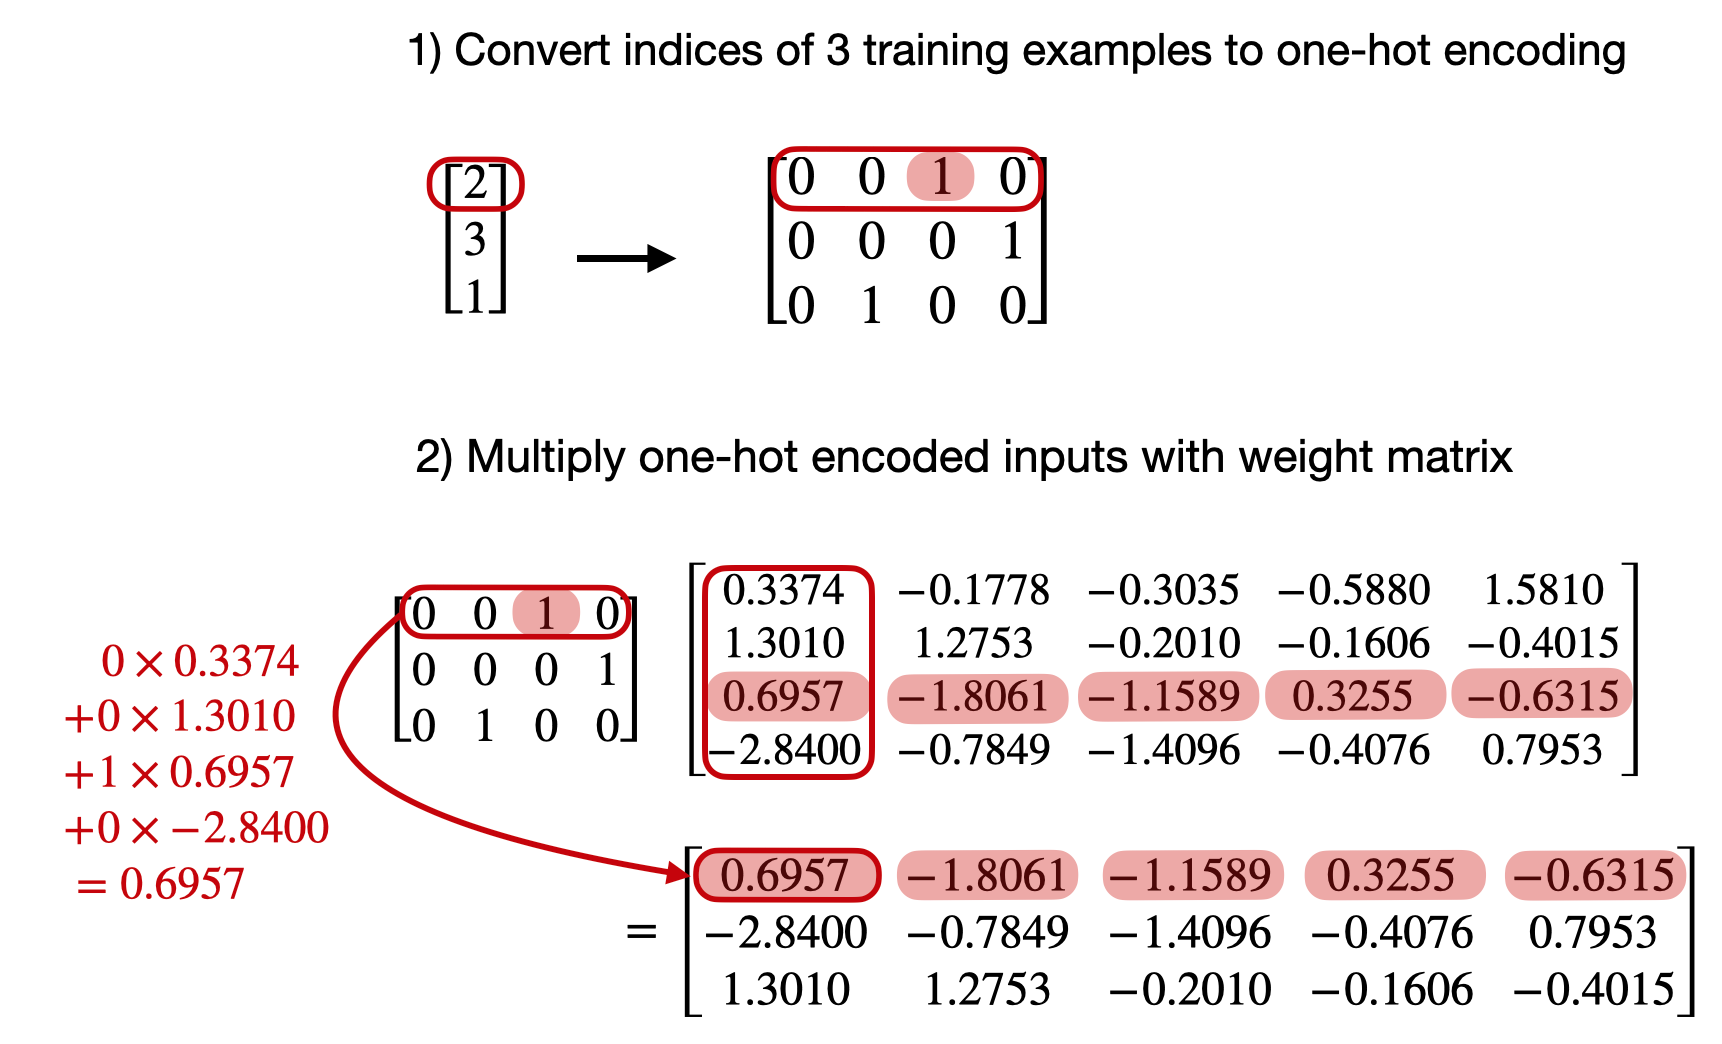

And for the second training example's token ID:

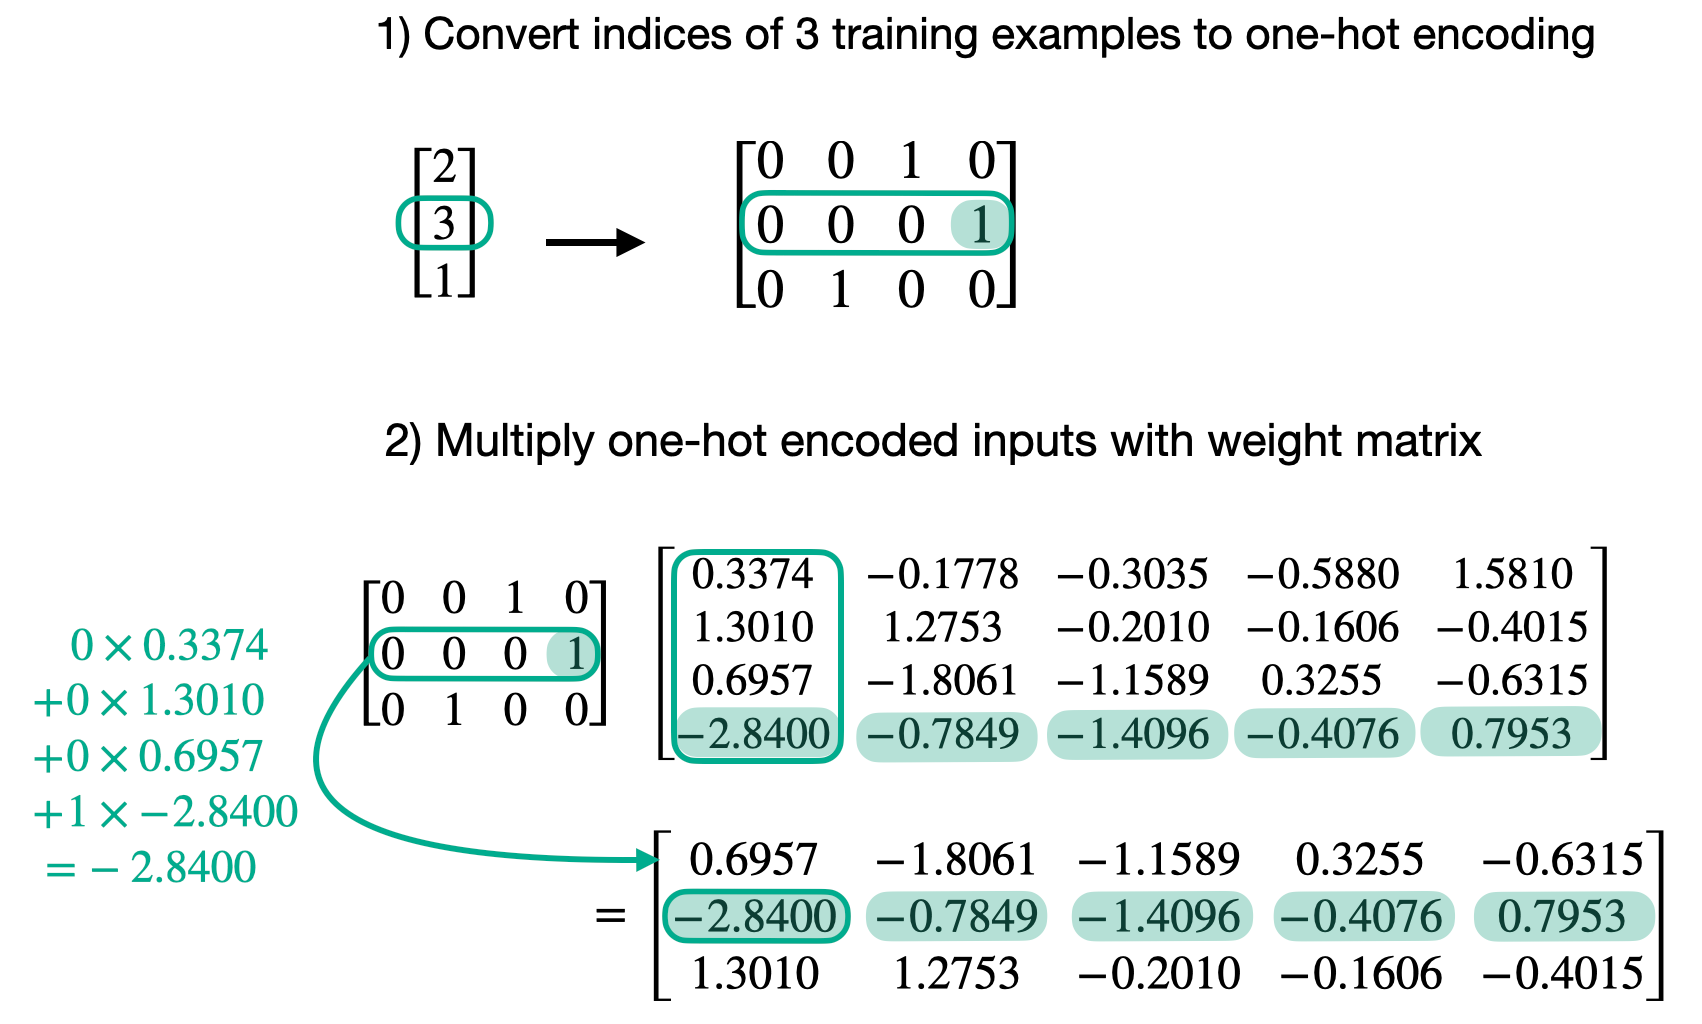

Since all but one index in each one-hot encoded row are 0 (by design), this matrix multiplication is essentially the same as a look-up of the one-hot elements. This use of the matrix multiplication on one-hot encodings is equivalent to the embedding layer look-up but can be inefficient if we work with large embedding matrices, because there are a lot of wasteful multiplications by zero.

Now we return to the book.

In [ ]:
# Instead of going one at a time we can get embeddings for all at once.
print(embedding_layer(input_ids))

In [ ]:
# Now try creating embeddings that are more realistic:
vocab_size = 50257  # Same size as the BPE tokeniser from earlier
output_dim = 256  # Get length-256 embedding vectors
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
max_length = 4
dataloader = create_dataloader_v1(
    raw_text_verdict,
    batch_size=8,
    max_length=max_length,
    stride=max_length,
    shuffle=False,
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

In [ ]:
# Now get the embeddings from those token IDs
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

In [ ]:
# Now create the positional embeddings
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)

In [ ]:
# Add these embeddings to the existing token embeddings, which adds the info about position to them
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)  # Shape remains unchanged